# Memory Usage Under Pressure

This experiment aims to evaluate the behavior of a given Python execution when under memory pressure.
On this notebook you will find:
- The problem statement
- The data collection for the experiment
- The evaluation of the experiment results.

## Problem statement

Since Python has a lazy garbage collector, if a given process is being executed and the host machine runs out of memory, Python will execute the garbage collector to allow the process to continue.
To evaluate this, we will execute the Envelope attribute under the following conditions:
- Without any memory pressure;
- With a memory pressure increasing with a step of 5% on each iteration

## Data Collection

In this section, we will outline the steps needed to collect the necessary data for our experiment.
The process is organized into the following steps:

1. **Setup Environment:**
  - Set up the environment with proper env variables and global constants to use during the experiment.

2. **Setup dependencies:**
  - Set up the virtual environment running this notebook with the required dependencies.

3. **Setup the output directory:**
  - On this step we will setup the output directory in which we will save the experiment results.

4. **Generate synthetic seismic data:**
  - Generate synthetic seismic data for a given shape.

5. **Collect data for each condition:**
  - Apply the envelope operator to the synthetic data under each of the evaluated conditions

After completing these steps, we will have the data generated by TraceQ to evaluate the memory usage of the envelope operator on different backends.

### Setup Environment

During the environment setup, we need to:
- Proper configure `PYTHONPATH`
- Setup dependencies

Below, we're configuring the `PYTHONPATH` to allow using the tools we've coded for the experiments

In [1]:
import os
import sys

seismic_path = os.path.abspath('../tools/seismic')
traceq_path = os.path.abspath('../tools/traceq')

if seismic_path not in sys.path:
    sys.path.append(seismic_path)

if traceq_path not in sys.path:
    sys.path.append(traceq_path)

print(sys.path)

['/home/delucca/.pyenv/versions/3.10.14/lib/python310.zip', '/home/delucca/.pyenv/versions/3.10.14/lib/python3.10', '/home/delucca/.pyenv/versions/3.10.14/lib/python3.10/lib-dynload', '', '/home/delucca/.pyenv/versions/3.10.14/envs/seismic-attributes-memory-profile/lib/python3.10/site-packages', '/home/delucca/src/unicamp/msc/seismic-attributes-memory-profile/tools/seismic', '/home/delucca/src/unicamp/msc/seismic-attributes-memory-profile/tools/traceq']


Now, lets setup some relevant global variables

In [29]:
from pprint import pprint

NUM_INLINES = 600
NUM_XLINES = 600
NUM_SAMPLES = 600

LOG_TRANSPORTS = ['CONSOLE', 'FILE']
LOG_LEVEL = 'DEBUG'

PRESSURE_STEP = 5  # Amount of pressure percentage to increase on every iteration

print('Experiment config:')
pprint({
    'NUM_INLINES': NUM_INLINES,
    'NUM_XLINES': NUM_XLINES,
    'NUM_SAMPLES': NUM_SAMPLES,
    'LOG_TRANSPORTS': LOG_TRANSPORTS,
    'LOG_LEVEL': LOG_LEVEL,
    'PRESSURE_STEP': PRESSURE_STEP,
}, indent=2, sort_dicts=True)

Experiment config:
{ 'LOG_LEVEL': 'DEBUG',
  'LOG_TRANSPORTS': ['CONSOLE', 'FILE'],
  'NUM_INLINES': 600,
  'NUM_SAMPLES': 600,
  'NUM_XLINES': 600,
  'PRESSURE_STEP': 5}


### Setup Dependencies

Before running this step, make sure you are running this notebook in the environment defined by the `.python-version` file.

In [3]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


We need to install DASF tools to execute the experiment

In [4]:
%pip install git+https://github.com/discovery-unicamp/dasf-core.git

  Cloning https://github.com/discovery-unicamp/dasf-core.git to /tmp/pip-req-build-m3eglf86
  Running command git clone --filter=blob:none --quiet https://github.com/discovery-unicamp/dasf-core.git /tmp/pip-req-build-m3eglf86
  Resolved https://github.com/discovery-unicamp/dasf-core.git to commit c4841cdeb92f596b0c011fe0480897731556c2dd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/jcfaracco/xpysom-dask to /tmp/pip-install-2k4kq5zz/xpysom-dask_9f5e8f962286486c8bc2cd8833c3c690
  Running command git clone --filter=blob:none --quiet https://github.com/jcfaracco/xpysom-dask /tmp/pip-install-2k4kq5zz/xpysom-dask_9f5e8f962286486c8bc2cd8833c3c690
  Resolved https://github.com/jcfaracco/xpysom-dask to commit c21d10b09f68d89663e2e967bdb5781f76a96b13
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... d

Now, we need to install a package that is private.
In order to do this, you can either use the HTTPS or SSH protocol.

In the next cell you can install with the protocol you prefer, just uncomment the one you want to use.

In [5]:
%pip install git+ssh://git@github.com/discovery-unicamp/dasf-seismic.git ### Using SSH
# %pip install git+https://<token>@github.com/discovery-unicamp/dasf-seismic.git ### Using HTTPS -> Don't forget to replate <token> with your own PAT

%pip install torch

  Cloning ssh://****@github.com/discovery-unicamp/dasf-seismic.git to /tmp/pip-req-build-_zszryeo
  Running command git clone --filter=blob:none --quiet 'ssh://****@github.com/discovery-unicamp/dasf-seismic.git' /tmp/pip-req-build-_zszryeo
  Resolved ssh://****@github.com/discovery-unicamp/dasf-seismic.git to commit 8037f403f79dd2a628a6d0d14543ead670eb01d4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/discovery-unicamp/dasf-core.git (to revision main) to /tmp/pip-install-n6ol9bog/dasf_a94388d3874c43f4ab1ef1866d312b2e
  Running command git clone --filter=blob:none --quiet https://github.com/discovery-unicamp/dasf-core.git /tmp/pip-install-n6ol9bog/dasf_a94388d3874c43f4ab1ef1866d312b2e
  Resolved https://github.com/discovery-unicamp/dasf-core.git to commit c4841cdeb92f596b0c011fe0480897731556c2dd
  Installing build dependencies ... done
  Getting requirements to build whe

Now, we need to install the dependencies for the tools we use during the experiment.

In [6]:
%pip install -r ../tools/seismic/requirements.txt
%pip install -r ../tools/traceq/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Setup output directory

In [40]:
import uuid
import os

from datetime import datetime

EXPERIMENT_ID = f'006-{datetime.now().strftime("%Y%m%d%H%M%S")}-{uuid.uuid4().hex[:6]}'
OUTPUT_DIR = f'../output/{EXPERIMENT_ID}'

os.makedirs(OUTPUT_DIR)

OUTPUT_DIR

'../output/006-20240912144642-76f980'

### Generate synthetic data

In [41]:
from seismic.data.synthetic import generate_and_save_synthetic_data

DATA_OUTPUT_DIR = f'{OUTPUT_DIR}/experiment'

synthetic_data_path = generate_and_save_synthetic_data(
    NUM_INLINES,
    NUM_XLINES,
    NUM_SAMPLES,
    output_dir=DATA_OUTPUT_DIR,
)
print(synthetic_data_path)

2024-09-12 14:46:43.580 | INFO     | seismic.data.synthetic:generate_and_save_synthetic_data:130 - Generating synthetic data for shape (600, 600, 600)
../output/006-20240912144642-76f980/data/600-600-600.segy


### Collecting Data without memory pressure

In [42]:
import traceq

from seismic.attributes import envelope

session_id = '00-memory-pressure'

traceq.load_config(
    {
        "output_dir": f'{OUTPUT_DIR}/profile-{session_id}',
        "logger": {
            "enabled_transports": LOG_TRANSPORTS,
            "level": LOG_LEVEL,
        },
        "profiler": {
            "session_id": session_id,
            "memory_usage": {
                "enabled_backends": ['kernel'],
            },
        },
    }
)

traceq.profile(envelope.run, synthetic_data_path)

2024-09-12 14:47:16.519 | INFO     | traceq.profiler.main:run_profiler:15 - Starting profiler
2024-09-12 14:47:16.521 | DEBUG    | traceq.profiler.builders:build_trace_hooks:20 - Building trace hooks for enabled metrics: [<Metric.MEMORY_USAGE: 'MEMORY_USAGE'>, <Metric.TIME: 'TIME'>]
2024-09-12 14:47:16.521 | INFO     | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:12 - Enabled memory usage backends: "[<MemoryUsageBackend.KERNEL: 'KERNEL'>]"
2024-09-12 14:47:16.522 | DEBUG    | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:23 - Loading backend: "kernel"
2024-09-12 14:47:16.523 | DEBUG    | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:31 - Loaded backend: "<module 'traceq.profiler.metrics.memory_usage.backends.kernel' from '/home/delucca/src/unicamp/msc/seismic-attributes-memory-profile/tools/traceq/traceq/profiler/metrics/memory_usage/backends/kernel.py'>"
2024-09-12 14:47:16.524 | DEBUG    | traceq.profiler.metrics.memory_usage.bui

### Collecting Data with Increasing Memory Pressure

In [43]:
from pathlib import Path;


def get_peak(profile_path):
    profile = load_profile(profile_path)
    data = profile['experiment']

    return max(item['kernel_memory_usage'] for item in data)


def get_unit(profile_path):
    profile = load_profile(profile_path)
    return profile['metadata']['kernel_memory_usage_unit']


zero_profile_path = [str(p) for p in Path(OUTPUT_DIR).rglob('*.prof')][0]
zero_profile_peak = get_peak(zero_profile_path)
zero_profile_unit = get_unit(zero_profile_path)

print(zero_profile_peak, zero_profile_unit)

6585160.0 kb


In [106]:
import subprocess
import os
import site
import tempfile

synthetic_data_parts = synthetic_data_path.split('/')
synthetic_data_filename = synthetic_data_parts.pop()

user_id = os.getuid()
group_id = os.getgid()

tools_dir = os.path.abspath("../tools")
synthetic_data_dir = os.path.abspath('/'.join(synthetic_data_parts))
output_dir = os.path.abspath(OUTPUT_DIR)
site_packages_dir = os.path.abspath(site.getsitepackages()[0])
mpl_config_dir = tempfile.mkdtemp()

pressures = list(range(PRESSURE_STEP, 100, PRESSURE_STEP))

for pressure in pressures:
    session_id = f"{pressure:02}-memory-pressure"
    pressure_percentage = pressure / 100
    max_memory = int(zero_profile_peak - (zero_profile_peak * pressure_percentage))
    print(f"Executing {pressure}% pressure data_generation")

    command = [
        "docker", "run", "--rm",
        "-v", f"{synthetic_data_dir}:/app/experiment",
        "-v", f"{tools_dir}:/app/tools",
        "-v", f"{output_dir}:/app/output",
        "-v", f"{site_packages_dir}:/app/site-packages",
        "-v", f"{mpl_config_dir}:/app/mpl_config",
        "-e", "MPLCONFIGDIR=/app/mpl_config",
        "-e", "OUTPUT_DIR=/app/output",
        "-e", "LOG_TRANSPORTS=CONSOLE,FILE",
        "-e", "LOG_LEVEL=DEBUG",
        "-e", f"SESSION_ID={session_id}",
        "-e", f"SYNTHETIC_DATA_FILENAME={synthetic_data_filename}",
        "--memory", f"{max_memory}k",
        "--memory-swap", "0k",
        "--user", f"{user_id}:{group_id}",
        "python:3.10-slim",
        "python", "-c",
        """
import sys

sys.path.append('/app/site-packages')
sys.path.append('/app/tools/traceq')
sys.path.append('/app/tools/seismic')

import os
import traceq

from seismic.attributes import envelope

session_id = os.environ.get('SESSION_ID')
output_dir = f'/app/output/profile-{session_id}'

traceq.load_config(
    {
        'output_dir': output_dir,
        'logger': {
            'enabled_transports': os.environ.get('LOG_TRANSPORTS').split(','),
            'level': os.environ.get('LOG_LEVEL'),
        },
        'profiler': {
            'session_id': session_id,
            'memory_usage': {
                'enabled_backends': ['kernel'],
            },
        },
    }
)

traceq.profile(envelope.run, f'/app/experiment/{os.environ.get("SYNTHETIC_DATA_FILENAME")}')
"""
    ]

    result = subprocess.run(command, capture_output=True, text=True)

    print(result.stdout)

    if len(result.stderr) > 0:
        import shutil

        shutil.rmtree(f'{output_dir}/profile-{session_id}')
        print(result.stderr)
        print(f"Stopped working on {pressure}% pressure")
        break

Executing 5% pressure experiment
2024-09-12 18:26:00.746 | INFO     | traceq.profiler.main:run_profiler:15 - Starting profiler
2024-09-12 18:26:00.746 | DEBUG    | traceq.profiler.builders:build_trace_hooks:20 - Building trace hooks for enabled metrics: [<Metric.MEMORY_USAGE: 'MEMORY_USAGE'>, <Metric.TIME: 'TIME'>]
2024-09-12 18:26:00.746 | INFO     | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:12 - Enabled memory usage backends: "[<MemoryUsageBackend.KERNEL: 'KERNEL'>]"
2024-09-12 18:26:00.746 | DEBUG    | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:23 - Loading backend: "kernel"
2024-09-12 18:26:00.746 | DEBUG    | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:31 - Loaded backend: "<module 'traceq.profiler.metrics.memory_usage.backends.kernel' from '/app/tools/traceq/traceq/profiler/metrics/memory_usage/backends/kernel.py'>"
2024-09-12 18:26:00.747 | DEBUG    | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:34

## Evaluating Experiment Results

In [107]:
from pathlib import Path;
from traceq import load_profile

profile_paths = [str(p) for p in Path(OUTPUT_DIR).rglob('*.prof')]
profile_names = [p.split('/')[-1].split('.')[0].split('-')[0] for p in profile_paths]
profiles = [load_profile(p) for p in profile_paths]

zipped_profiles = list(zip(profile_names, profiles))

print(profile_paths)

['../output/006-20240912144642-76f980/profile-30-memory-pressure/30-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-05-memory-pressure/05-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-50-memory-pressure/50-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-00-memory-pressure/00-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-10-memory-pressure/10-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-15-memory-pressure/15-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-35-memory-pressure/35-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-45-memory-pressure/45-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-25-memory-pressure/25-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-20-memory-pressure/20-memory-pressure.prof', '../output/006-20240912144642-76f980/profile-40-memory-pressure/40-memory-pressure.prof']


Now, lets parse the memory and execution times

In [108]:
profile_memory_usage_history = [
    (
        name,
        profile['metadata']['kernel_memory_usage_unit'],
        [entry['kernel_memory_usage'] for entry in profile['experiment']],
    ) for name, profile in zipped_profiles
]
profile_execution_time = [
    (
        name,
        profile['metadata']['unix_timestamp_unit'],
        profile['experiment'][-1]['unix_timestamp'] - profile['experiment'][0]['unix_timestamp'],
    ) for name, profile in zipped_profiles
]

print(profile_memory_usage_history[0])
print(profile_execution_time)

('30', 'kb', [50620.0, 50620.0, 51636.0, 51940.0, 52176.0, 52780.0, 53456.0, 53632.0, 54232.0, 54512.0, 56516.0, 79524.0, 79708.0, 80248.0, 80488.0, 81016.0, 81016.0, 82464.0, 82464.0, 82464.0, 83280.0, 83464.0, 84972.0, 88864.0, 90124.0, 90796.0, 90796.0, 90796.0, 91616.0, 92404.0, 101476.0, 109032.0, 115248.0, 123440.0, 131880.0, 134040.0, 134892.0, 136144.0, 136392.0, 137416.0, 138588.0, 139480.0, 141044.0, 142312.0, 143084.0, 143828.0, 144844.0, 171800.0, 173476.0, 174100.0, 175740.0, 176348.0, 177324.0, 178164.0, 178164.0, 178532.0, 185112.0, 186700.0, 187752.0, 188484.0, 188748.0, 190452.0, 191872.0, 191872.0, 192208.0, 192812.0, 193076.0, 193340.0, 194132.0, 196508.0, 196508.0, 197232.0, 198084.0, 200724.0, 202308.0, 202828.0, 202828.0, 202828.0, 202828.0, 202828.0, 202828.0, 202828.0, 206404.0, 208252.0, 208252.0, 208344.0, 208344.0, 208560.0, 208824.0, 208824.0, 208824.0, 209300.0, 209884.0, 210544.0, 211092.0, 212632.0, 213680.0, 214892.0, 215552.0, 216532.0, 217692.0, 218088

Now, lets create the plots

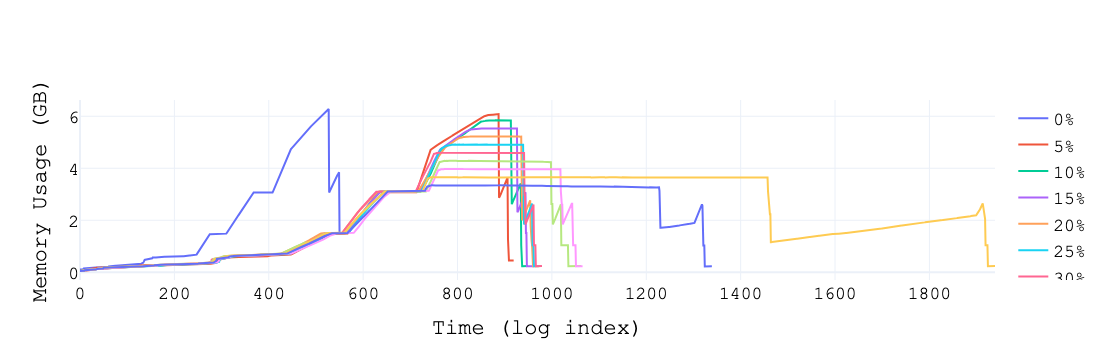

In [109]:
import plotly.graph_objects as go

KB_TO_GB = 1048576

x_values_memory = []
y_values_memory_gb = []

sorted_profile_memory_usage_history = sorted(profile_memory_usage_history, key=lambda x: int(x[0]))

fig1 = go.Figure()

for percentage, unit, values in sorted_profile_memory_usage_history:
    y_values_memory_gb = [value / KB_TO_GB for value in values]
    x_values_memory = list(range(len(values)))

    fig1.add_trace(go.Scatter(
        x=x_values_memory,
        y=y_values_memory_gb,
        mode='lines',
        name=f'{int(percentage)}%',
    ))

fig1.update_layout(
    xaxis_title="Time (log index)",
    yaxis_title="Memory Usage (GB)",
    xaxis=dict(showgrid=True, zeroline=True),
    yaxis=dict(showgrid=True, zeroline=True, exponentformat="E"),
    font=dict(family="Courier New, monospace", size=18, color="Black"),
    template="plotly_white",
    showlegend=True
)

fig1.write_image(f'{OUTPUT_DIR}/memory-usage-over-time.pdf', format="pdf", engine="kaleido")
fig1.show()

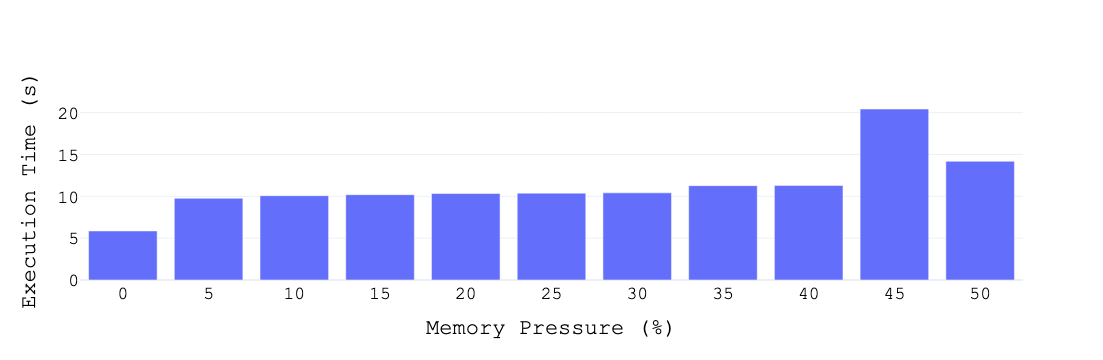

In [110]:
import plotly.graph_objects as go

sorted_profile_execution_time = sorted(profile_execution_time, key=lambda x: int(x[0]))
x_values_execution = [str(int(item[0])) for item in sorted_profile_execution_time]
y_values_execution = [item[2] / 1000 for item in sorted_profile_execution_time]

fig2 = go.Figure()
fig2.add_trace(go.Bar(x=x_values_execution, y=y_values_execution))

fig2.update_layout(
    xaxis_title="Memory Pressure (%)",
    yaxis_title="Execution Time (s)",
    font=dict(family="Courier New, monospace", size=18, color="Black"),
    template="plotly_white"
)

fig1.write_image(f'{OUTPUT_DIR}/execution-time-for-backend.pdf', format="pdf", engine="kaleido")
fig2.show()